In [1]:
import numpy as np
from scipy.misc import imresize
import pylab
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform, filters
import sys, pylab, operator, csv
#import util
import os
import urllib

%matplotlib notebook

%load_ext autoreload
%autoreload 2

import caffe

from helpers import *
from heatmaps import *
from repro_EB_figs import *
from optimize_mask import *

In [2]:
gpu = 1
net_type = 'googlenet'

caffe.set_device(gpu)
caffe.set_mode_gpu()

net = get_net(net_type)

# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 224, 224)
conv1/7x7_s2	(10, 64, 112, 112)
pool1/3x3_s2	(10, 64, 56, 56)
pool1/norm1	(10, 64, 56, 56)
conv2/3x3_reduce	(10, 64, 56, 56)
conv2/3x3	(10, 192, 56, 56)
conv2/norm2	(10, 192, 56, 56)
pool2/3x3_s2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_0	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_1	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_3	(10, 192, 28, 28)
inception_3a/1x1	(10, 64, 28, 28)
inception_3a/3x3_reduce	(10, 96, 28, 28)
inception_3a/3x3	(10, 128, 28, 28)
inception_3a/5x5_reduce	(10, 16, 28, 28)
inception_3a/5x5	(10, 32, 28, 28)
inception_3a/pool	(10, 192, 28, 28)
inception_3a/pool_proj	(10, 32, 28, 28)
inception_3a/output	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_0	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_1	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_2	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_spl

In [3]:
labels_desc = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_words.txt', str, delimiter='\t')
synsets = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t')
(paths, labels) = read_imdb('/home/ruthfong/packages/caffe/data/ilsvrc12/annotated_train_heldout_imdb.txt')
data_desc = 'train_heldout'
paths = np.array(paths)
labels = np.array(labels)
ann_dir = '/data/ruthfong/ILSVRC2012/annotated_train_heldout_ground_truth_annotations'
ann_paths = [os.path.join(ann_dir, f) for f in os.listdir(ann_dir)]
res_dir = '/data/ruthfong/neural_coding/pycaffe_results'
mask_rel_dir = 'googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
#mask_rel_dir = 'googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
mask_paths = [os.path.join(res_dir, mask_rel_dir, '%d.npy' % x) for x in range(len(labels))]

In [16]:
net_transformer = get_ILSVRC_net_transformer(net)
alphas = np.arange(0,1,0.01)
mask_flip = True
bb_method = 'min_max_diff'
for i in range(10):
    img = net_transformer.preprocess('data', caffe.io.load_image(paths[i]))
    null_img = net_transformer.preprocess('data', get_blurred_img(paths[i]))
    target = np.zeros(1000)
    target[labels[i]] = 1
    orig_score = forward_pass(net, img, target)
    null_score = forward_pass(net, null_img, target)
    f, ax = plt.subplots(1,1)
    heatmap_types = ['mask', 'saliency', 'guided_backprop', 'excitation_backprop']
    for h in heatmap_types:
        resize = None
        if h == 'mask':
            heatmap = np.load(mask_paths[i])
            if mask_flip:
                heatmap = 1 - heatmap            
        else:
            top_name = 'loss3/classifier'
            if h == 'excitation_backprop':
                bottom_name = 'pool2/3x3_s2'
                norm_deg = -1
                resize = (224,224)
            else:
                bottom_name = 'data'
                norm_deg = np.inf
            heatmap = compute_heatmap(net, net_transformer, paths[i], labels[i], h, top_name, top_name,
                    outputBlobName = bottom_name, outputLayerName = bottom_name, norm_deg = norm_deg, gpu = gpu)
        bb_sizes = np.zeros(len(alphas))
        scores = np.zeros(len(alphas))
        for j in range(len(alphas)):
            alpha = alphas[j]
            (x0,y0,x1,y1) = getbb_from_heatmap(heatmap, alpha, method = bb_method, resize = resize)
            mask = np.ones((224,224))
            mask[y0:y1,x0:x1] = 0
            bb_size = (y1-y0)*(x1-x0)
            bb_sizes[j] = bb_size
            comp_img = img * mask + null_img * (1 - mask)
            masked_score = forward_pass(net, comp_img, target)
            scores[j] =(masked_score-null_score)/float(orig_score-null_score)
        ax.semilogx(bb_sizes, scores, label = h)
    ax.legend(loc='upper center')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [23]:
net_transformer = get_ILSVRC_net_transformer(net)
alphas = np.arange(0,1,0.01)
mask_flip = True
bb_method = 'min_max_diff'
heatmap_types = ['mask', 'saliency', 'guided_backprop', 'excitation_backprop']
num_imgs = 100
threshold = 1e-2
best_bb_sizes = np.zeros((len(heatmap_types), num_imgs))
for i in range(num_imgs):
    img = net_transformer.preprocess('data', caffe.io.load_image(paths[i]))
    null_img = net_transformer.preprocess('data', get_blurred_img(paths[i]))
    target = np.zeros(1000)
    target[labels[i]] = 1
    orig_score = forward_pass(net, img, target)
    null_score = forward_pass(net, null_img, target)
    for hh in range(len(heatmap_types)):
        h = heatmap_types[hh]
        resize = None
        if h == 'mask':
            heatmap = np.load(mask_paths[i])
            if mask_flip:
                heatmap = 1 - heatmap            
        else:
            top_name = 'loss3/classifier'
            if h == 'excitation_backprop':
                bottom_name = 'pool2/3x3_s2'
                norm_deg = -1
                resize = (224,224)
            else:
                bottom_name = 'data'
                norm_deg = np.inf
            heatmap = compute_heatmap(net, net_transformer, paths[i], labels[i], h, top_name, top_name,
                    outputBlobName = bottom_name, outputLayerName = bottom_name, norm_deg = norm_deg, gpu = gpu)
        bb_sizes = np.zeros(len(alphas))
        scores = np.zeros(len(alphas))
        for j in range(len(alphas)):
            alpha = alphas[j]
            (x0,y0,x1,y1) = getbb_from_heatmap(heatmap, alpha, method = bb_method, resize = resize)
            mask = np.ones((224,224))
            mask[y0:y1,x0:x1] = 0
            bb_size = (y1-y0)*(x1-x0)
            bb_sizes[j] = bb_size
            comp_img = img * mask + null_img * (1 - mask)
            masked_score = forward_pass(net, comp_img, target)
            scores[j] =(masked_score-null_score)/float(orig_score-null_score)
        try:
            best_i = np.where(scores <= threshold)[0][0]
        except:
            best_i = np.argmin(scores)
        best_bb_sizes[hh][i] = bb_sizes[best_i]
    print i

f = open(out_path, f)
np.savetxt(f, best_bb_sizes)
f.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [24]:
print 'heatmap_type', 'best_bb_size_mean', 'best_bb_size_std'
for hh in range(len(heatmap_types)):
    print heatmap_types[hh], best_bb_sizes[hh].mean(), best_bb_sizes[hh].std()

mask 49408.53 1270.04166432
saliency 49671.89 483.844022284
guided_backprop 49615.48 821.363116776
excitation_backprop 49330.76 2291.44225814


In [4]:
base_dir = '/home/ruthfong/neural_coding/deletion_game/googlenet_train_heldout/googlenet_train_heldout_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
heatmap_types = ['saliency', 'guided_backprop', 'excitation_backprop', 'contrast_excitation_backprop', 'mask']
num_imgs = 5000
alphas = np.arange(0,1,0.01)
scores = np.zeros((len(heatmap_types), num_imgs, len(alphas)))
bb_sizes = np.zeros((len(heatmap_types), num_imgs, len(alphas)))

for i in range(len(heatmap_types)):
    heatmap_type = heatmap_types[i]
    bb_size = np.loadtxt(os.path.join(base_dir, 'bb_sizes_num_imgs_5000_%s.txt' % heatmap_type))
    score = np.loadtxt(os.path.join(base_dir, 'alpha_scores_num_imgs_5000_%s.txt' % heatmap_type))
    bb_sizes[i,...] = bb_size[:num_imgs]
    scores[i,...] = score[:num_imgs]

In [5]:
thresholds = np.arange(0.01,1.01,0.01)
best_bb_sizes = np.zeros((len(heatmap_types),num_imgs,len(thresholds)))
count = 0
normalize = False
for i in range(len(thresholds)):
    threshold = thresholds[i]
    for j in range(num_imgs):
        for k in range(len(heatmap_types)):
            try: 
                best_i = np.where(scores[k][j] <= threshold)[0][-1]
                best_bb_sizes[k][j][i] = bb_sizes[k][j][best_i]
            except:
                #print j, heatmap_types[k]
                best_bb_sizes[k][j][i] = np.nan
                count += 1
        if normalize:
            best_bb_sizes[:,j,i] = best_bb_sizes[:,j,i]/float(best_bb_sizes[0,j,i])
print count

25267


In [6]:
#print 'heatmap_type', 'best_bb_size_mean', 'best_bb_size_std'
means = np.zeros((len(thresholds), len(heatmap_types)))
stds = np.zeros((len(thresholds), len(heatmap_types)))
counts = np.zeros((len(thresholds), len(heatmap_types)))

for i in range(len(thresholds)):
    for j in range(len(heatmap_types)):
        x = best_bb_sizes[j,:,i]
        x = x[~np.isnan(x)]
        #print thresholds[i], heatmap_types[j], x.mean(), x.std()
        means[i,j] = x.mean()
        stds[i,j] = x.std()
        counts[i,j] = len(x)

0.2 (5,) (5,)
(5,) (5,)
0.1 (5,) (5,)
(5,) (5,)
0.05 (5,) (5,)
(5,) (5,)
0.01 (5,) (5,)
(5,) (5,)
(4, 5)
['saliency', 'guided_backprop', 'excitation_backprop', 'contrast_excitation_backprop', 'mask']


<IPython.core.display.Javascript object>


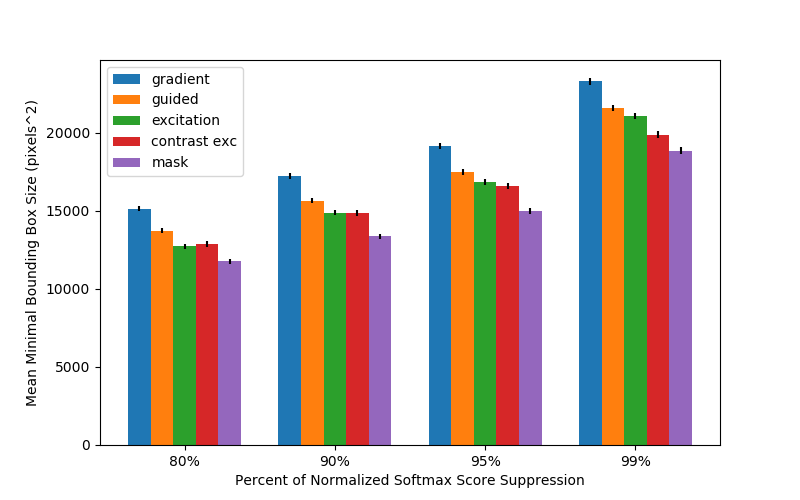

(4,)
(4,)
(4,)
(4,)
(4,)


In [60]:
#threshold_points = [0.2,0.1,0.05,0.01]
pylab.rcParams['figure.figsize'] = [8,5]
threshold_points = [19,9,4,0]
bar_data = np.zeros((len(threshold_points),len(heatmap_types)))
bar_se = np.zeros((len(threshold_points), len(heatmap_types)))
width = 0.15
#print thresholds
for i in range(len(threshold_points)):
    t_i = threshold_points[i]
    #t_i = np.where(threshold_points[i] == thresholds)[0]
    print thresholds[t_i],means[t_i].shape, bar_data[i,:].shape
    bar_data[i,:] = means[t_i]
    print stds[t_i].shape, counts[t_i].shape
    bar_se[i,:] = np.true_divide(stds[t_i],counts[t_i]**0.5)
print bar_data.shape
print heatmap_types
f, ax = plt.subplots()
for i in range(len(heatmap_types)):
    print bar_data[:,i].shape
    ax.bar([j+i*width for j in range(len(threshold_points))], bar_data[:,i], width, label=heatmap_types[i], yerr=bar_se[:,i])

#women_means = (25, 32, 34, 20, 25)
#women_std = (3, 5, 2, 3, 3)
#rects2 = ax.bar(ind + ind*width, women_means, width, color='y', yerr=women_std)

# add some text for labels, title and axes ticks
ax.set_xlabel('Percent of Normalized Softmax Score Suppression')
ax.set_ylabel('Mean Minimal Bounding Box Size (pixels^2)')
ax.set_xticks(np.arange(len(threshold_points)) + 2*width)
ax.set_xticklabels(('80%', '90%', '95%', '99%'))

ax.legend(('gradient', 'guided', 'excitation', 'contrast exc', 'mask'))

plt.savefig('/home/ruthfong/neural_coding/paper_figures/deletion_game_bar.pdf', bbox_inches='tight', pad_inches=0.0)

<IPython.core.display.Javascript object>


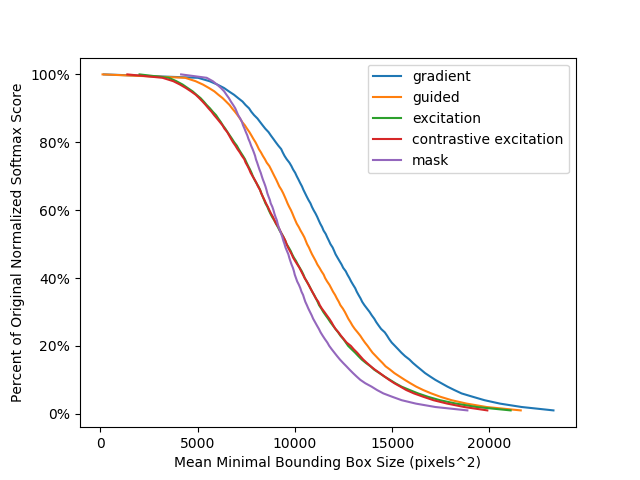

In [14]:
import matplotlib.ticker as mtick

stderr = stds/np.sqrt(counts)
f,ax = plt.subplots(1,1)
#ax.plot(thresholds, means)
for i in range(len(heatmap_types)):
    ax.plot(means[:,i], thresholds*100)
    #ax.errorbar(means[:,i],thresholds,xerr=stderr[:,i], label=heatmap_types[i])
ax.set_ylabel('Percent of Original Normalized Softmax Score')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
#ax.set_xlim(ax.get_xlim()[::-1])
if normalize:
    ax.set_xlabel('Normalized Mean Minimal Bounding Box Size (pixels^2)')
else:
    ax.set_xlabel('Mean Minimal Bounding Box Size (pixels^2)')
#ax.legend(heatmap_types, loc='upper center')
ax.legend(('gradient', 'guided', 'excitation', 'contrastive excitation', 'mask'), loc='upper right')
plt.savefig('/home/ruthfong/neural_coding/paper_figures/deletion_game_unnormalized_reverse.pdf', bbox_inches='tight')

In [9]:
print 'heatmap_type', 'best_bb_size_mean', 'best_bb_size_std'
for hh in range(len(heatmap_types)):
    print heatmap_types[hh], means[0,hh], stds[0,hh]

heatmap_type best_bb_size_mean best_bb_size_std
mask 18863.7724954 14098.4024564
saliency 23289.4489713 13984.1577471
guided_backprop 21608.0790063 13912.1586352
excitation_backprop 21088.9125917 14240.3839286
contrast_excitation_backprop 19889.9179827 14346.3028548


(5000, 100)
